### Part 1: Useful Functions

In [226]:
def get_model( temp ):
    '''
    Function opens Phoenix file of specified temperature in 100 Kelvin increments from 2300 to 12000 Kelvin.
    Parameters
    ----------
    temp: str
        Desired temperature in 100K increments from 2300 to 12,000 Kelvin
        
    Returns
    -------
    wavelength: array
        Associated wavelengths for flux measurements from Phoenix FITS file, in Angstroms
        
    flux: array
        Flux measurements from Phoenix FITS file, in erg/s/cm^2
        
    temp: str
        See Parameters
    '''
    model_file = 'Med_Res_10K_Grid/lte0' + temp + '-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    #what are the numbers here? -4.50-0.0
    hdulist = fits.open(model_file)
    flux = hdulist[0].data
    wavelength = np.exp(hdulist[0].header[('CRVAL1')]+hdulist[0].header[('CDELT1')]*np.arange(0,212027))/(10**4)
    return wavelength,flux

In [227]:
def getMag_hires(band,wavelength,flux):
    #PHOENIX flux is erg/s/cm^2/cm
    
    import numpy as np
    import scipy.interpolate as interp
    
    wavelength= wavelength*1.0E4 #convert input wavelength to Angstroms
    flux=flux*1.0E-8 #convert input flux to ergs/cm^2/s/Angstrom
    
    '''if band=='Ks':
        bandwav,bandpass=np.loadtxt("../DATA/Ks_2MASS.txt",unpack=True)    # micron
        center=2.159
        F0= 4.283E-14        # W cm^-2 micron^-1

    elif band=='H':
        bandwav,bandpass=np.loadtxt("../DATA/H_2MASS.txt",unpack=True)
        center=1.662
        F0= 1.133E-13
    
    elif band=='J':
        bandwav,bandpass=numpy.loadtxt("../DATA/J_2MASS.txt",unpack=True)
        center=1.235
        F0= 3.129E-13'''
    
    #All filters are in Angstroms
    #code was written when: Units of Ks, H and J filters are microns, all other filters in Angstroms
    
    
    if band=='Ks':
        bandwav,bandpass=np.loadtxt('filters/k_filter.txt',unpack=True)
        center=2.159*1.0E4        #Angstroms
        F0=4.283E-14        #KsHJUBVRI F0 have units W cm^-2 micron^-1
   
    elif band=='H':
        bandwav,bandpass=np.loadtxt('filters/h_filter.txt',unpack=True)
        center=1.662*1.0E4
        F0=1.133E-13

    elif band=='J':
        bandwav,bandpass=np.loadtxt('filters/j_filter.txt',unpack=True)
        center=1.235*1.0E4
        F0=3.129E-13

    elif band=='U':
        bandwav,bandpass=np.loadtxt('filters/bessell_U.dat',unpack=True)
        center=0.365*1.0E4
        F0=4.19E-12

    elif band=='B':
        bandwav,bandpass=np.loadtxt('filters/bessell_B.dat',unpack=True)
        center=0.445*1.0E4
        F0=6.60E-12

    elif band=='V':
        bandwav,bandpass=np.loadtxt('filters/bessell_V.dat',unpack=True)
        center=0.551*1.0E4
        F0=3.61E-12

    elif band=='R':
        bandwav,bandpass=np.loadtxt('filters/bessell_R.dat',unpack=True)
        center=0.658*1.0E4
        F0=2.25E-12

    elif band=='I':
        bandwav,bandpass=np.loadtxt('filters/bessell_I.dat',unpack=True)
        center=0.806*1.0E4
        F0=1.22E-12
                                      #SDSS centers/widths/F0 from http://www.astronomy.ohio-state.edu/~martini/usefuldata.html
    elif band=='u':                   #NOTE: ugriz filters are on the AB magnitude system, KsHJUBVRI are on the Vega system
        bandwav,bandpass=np.loadtxt('filters/u_filter.txt',unpack=True)
        center=0.356*1.0E4         
        F0=0.8595E-11        #ugriz F0 have units erg/cm^2/s/Angstrom
        
    elif band=='g':
        bandwav,bandpass=np.loadtxt('filters/g_filter.txt',unpack=True)
        center=0.483*1.0E4
        F0=0.4669E-11
        
    elif band=='r':
        bandwav,bandpass=np.loadtxt('filters/r_filter.txt',unpack=True)
        center=0.626*1.0E4
        F0=0.2780E-11
    
    elif band=='i':
        bandwav,bandpass=np.loadtxt('filters/i_filter.txt',unpack=True)
        center=0.767*1.0E4
        F0=0.1852E-11
    
    elif band=='z':
        bandwav,bandpass=np.loadtxt('filters/u_filter.txt',unpack=True)
        center=0.910*1.0E4
        F0=0.1315E-11
    
    '''elif band=='Kep':
        bandwav,bandpass=np.loadtxt()
        center=6400/10**4
        F0= '''
    
    if band=='Ks' or band=='H' or band=='J' or band=='U' or band=='V' or band=='B' or band=='R' or band=='I':
        F0=F0*1.0E3 #convert to ergs/cm^2/s/Angstrom
        
    #other bands already have 0-point flux in ergs/cm^2/s/Angstrom

    filterband=np.zeros(wavelength.size)

    
    bandinterp=interp.interp1d(bandwav,bandpass)
            #1D function between bandwav(x) and bandpass(y), y=f(x)
        
    inband=np.logical_and(wavelength>bandwav[0],wavelength<bandwav[-1] )
            #Array of 'True's where wavelength is in range of bandwav, 'False's outside of that range. Basically just an index of bandwav in wavelength array
        
    filterband[inband]=bandinterp(wavelength[inband])
            #Ignore all values of bandpass outside of filter range. Now filterband is the same shape as wavelength and flux
        
    dwav=np.zeros(wavelength.size)
        
    dwav[0:-1]=wavelength[1:]-wavelength[0:-1]
    
    
    mag=2.5*np.log10((np.sum(F0*dwav*filterband))/(np.sum(flux*dwav*filterband)))
    
    return band,mag
    

In [228]:
def getFMext(x,R):
    
    """ Fitzpatrick 1999, spectroscopic

        Inputs:  x = inverse wavelength in microns
                R = ratio of A_V to E(B-V)
                
        Outputs:  returns Al/AV in magnitude units
    """
    
    from scipy.interpolate import interp1d
    
    import numpy as np

    f99_anchor = 1.0E4 / np.array([np.inf, 26500., 12200., 6000., 5470., 4670., 4110., 2700., 2600.]) #microns
    #np.array creates an array
    #np.inf sets value to infinity
    #"anchor" wavelengths for the function to come--what is the pattern here?
    #x axis values
    
    a6000=-0.426+1.0044*R
    a5470=-0.050+1.0016*R
    a4670= 0.701+1.0016*R
    a4110= 1.208+1.0032*R-0.00033*R**2
    #for values in array, apply R in some way
    #create new values using R. Where do coefficients of R come from?

    af99_anchor = np.array([0.0, 0.265, 0.829, a6000, a5470, a4670, a4110, 6.265, 6.591])/3.1
    #same shape as previous array so function can be created
    #create a new array, replacing numbers from original array with their corresponding constant
    #divide by 3.1: comparing to the "standard" R value of 3.1?
    #y axis values--tell extinction pattern of "anchor values"?
    
    f=interp1d(f99_anchor,af99_anchor, kind='cubic') 
    #create a 2-variable function between the two arrays, wavelength and magnitude of extinction
    #find a function of frequency (1/wavelength)
    
    return f(x)
    #A_lambda/A_V:a different value for each input wavelength (continuous function)

In [229]:
import numpy as np
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from scipy.interpolate import interp1d

from astropy.io import fits

%matplotlib inline

### Part 2: Spectra Models for Various Extinction Magnitudes

In [230]:
X=get_model('5700')[0]
Y=get_model('5700')[1]

In [231]:
AlAv=getFMext(1.0/X,3.1)
#Use Z=Y*10.0**(-0.4*AlAv) for reddened spectra
#Multiply exponent by desired magnitude of extinction

In [232]:
Z=Y*10.0**(-0.4*AlAv) #use reddened spectra as new initial spectra

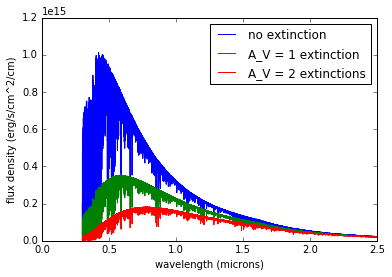

In [233]:
plt.plot(X,Y,label="no extinction")
plt.plot(X,Y*10.0**(-0.4*AlAv),label="A_V = 1 extinction")
plt.plot(X,Y*10.0**(-0.4*AlAv*2.0),label="A_V = 2 extinctions")
plt.legend()
plt.xlabel("wavelength (microns)")
plt.ylabel("flux density (erg/s/cm^2/cm)")
#plot not doing what expected, looks scaled, not extinguished, before 0.5 microns

### Part 3: Photometry (Band Magnitudes and Extinction)

In [234]:
Q=Z*10.0**(-0.4*AlAv)
P=Q*10.0**(-0.4*AlAv)

In [235]:
def getMags(a,b,c,d,e):
    #should change variable names here, but using for now for expediency
    KmagA=getMag_hires('Ks',a,b)
    VmagA=getMag_hires('V',a,b)
    VminKA=VmagA[1]-KmagA[1]

    KmagB=getMag_hires('Ks',a,c) 
    VmagB=getMag_hires('V',a,c)
    VminKB=VmagB[1]-KmagB[1]

    KmagC=getMag_hires('Ks',a,d)
    VmagC=getMag_hires('V',a,d)
    VminKC=VmagC[1]-KmagC[1]

    KmagD=getMag_hires('Ks',a,e)
    VmagD=getMag_hires('V',a,e)
    VminKD=VmagD[1]-KmagD[1]
    return (KmagA,VmagA,VminKA,KmagB,VmagB,VminKB,KmagC,VmagC,VminKC,KmagD,VmagD,VminKD)


#convert some wavelengths to microns, but use angstrom keyword for each one
#'Ks' filter is expecting a spectrum input in microns 
#'V' filter is expecting a spectrum input in angstroms, so no conversion needed

#conversion previously necessary because of these lines of code:
#  #if band=='U'or band=='B'or band=='V'or band=='R'or band=='I'or band=='u'or band=='g'or band=='r'or band=='i'or band=='z':
        #bandwav=[i/1.0E4 for i in bandwav]                     #Convert bandwav from Angstroms to microns
                                                               #now all filters are in Angstroms--see line below

#now using bandwav=[i/1.0E4 for i in bandwav], conversion not necessary (applies to all filters)


In [236]:
getMags(X,Y,Z,Q,P)

(('Ks', -39.920097693935752),
 ('V', -38.343470695640598),
 1.5766269982951542,
 ('Ks', -39.807455966676685),
 ('V', -37.361298235336534),
 2.4461577313401506,
 ('Ks', -39.694851121264783),
 ('V', -36.38639633975275),
 3.3084547815120331,
 ('Ks', -39.582283123757833),
 ('V', -35.418870078669343),
 4.1634130450884896)

### Part 4: Checking extinction for a spectrum plus a blackbody

In [237]:
# Build a wavelength vector
dwav=0.001
wav=np.arange(0.29,2.51,dwav) #wavelength = microns #range of PHOENIX spectra is 0.3 to 2.5 microns

def planck_sed(wav,T):
# Source blackbody emission: wavelength in microns, temp in Kelvin
# Output is SED (Spectral Energy Distribution)
# Units are SI W/m^2/m

    l=wav*1E-6
    h=6.62606957*(10**-34.0)
    c=3.00*(10**8.0)
    k=1.3806488*(10**-23.0)
    
    x=(2.0*3.14*h*c**2.0/l**5.0)
    
    exponent = h*c/(k*T*l)
                 
    ex = np.exp(exponent)-1

    PLANCK=(x)*(ex**-1)
    
    return PLANCK*(10**7)/10000/(10**10)

In [238]:
modelwavelengths = (get_model('5700'))[0] #microns
modelflux = (get_model('5700')[1])/10000/10000 #erg/cm^2/s/Angstrom

fluxdist = (planck_sed(wav,1200)) #units: J/s/m^2/m conv to erg/cm^2/s/Angstrom

#flux distribution for a 1200K blackbody
#1.0E4 might be arbitrary... check units

bbwavelengths = wav #microns
bbflux = fluxdist 

blackbodyf= interp1d(bbwavelengths, bbflux)
#interpolate each to make a continuous function for bb flux
#add fluxes together, keeping wavelength on the same scale


totalflux = blackbodyf(modelwavelengths) + modelflux


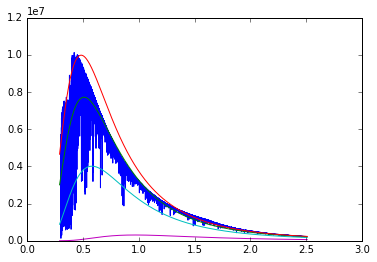

In [239]:
plt.plot(modelwavelengths, modelflux)
plt.plot(wav, planck_sed(wav,5700))
plt.plot(wav,planck_sed(wav,6000))
plt.plot(wav,planck_sed(wav,5000))
plt.plot(wav,planck_sed(wav,3000))

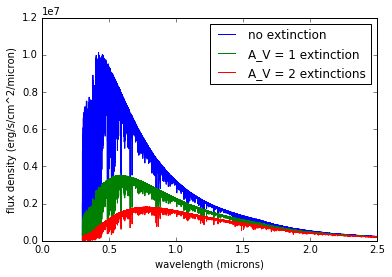

In [240]:
X=modelwavelengths    #clean up--reusing variables
Y=totalflux           #clean up--reusing variables
Z=Y*10.0**(-0.4*AlAv) #using reddened spectra as new initial spectra
AlAv=getFMext(1.0/X,3.1)
#Use Z=Y*10.0**(-0.4*AlAv) for reddened spectra
#Multiply exponent by desired magnitude of extinction

plt.plot(X,Y,label="no extinction")
plt.plot(X,Y*10.0**(-0.4*AlAv),label="A_V = 1 extinction")
plt.plot(X,Y*10.0**(-0.4*AlAv*2.0),label="A_V = 2 extinctions")
plt.legend()
plt.xlabel("wavelength (microns)")
plt.ylabel("flux density (erg/s/cm^2/micron)")

In [241]:
Q=Z*10.0**(-0.4*AlAv)
P=Q*10.0**(-0.4*AlAv)

In [242]:
getMags(X,Y,Z,Q,P)

(('Ks', -19.92848062149103),
 ('V', -18.343470763647307),
 1.5850098578437226,
 ('Ks', -19.815847190427945),
 ('V', -17.36129830253304),
 2.4545488878949051,
 ('Ks', -19.703250643170094),
 ('V', -16.38639641357312),
 3.3168542295969736,
 ('Ks', -19.590690938897072),
 ('V', -15.418870159727939),
 4.1718207791691331)

In [243]:
#calculate V-K for each iteration
#plot V-K vs V for each star

|Number of extinctions|V|K|V-K|
|--|--|--|--|
|0|-28.35|-31.87|3.52|
|1|-27.36|-31.76|4.39|
|2|-26.39|-31.67|5.26|
|3|-25.43|-31.54|6.11|

### Part 5: Plotting V-K vs V

In [244]:
starplusbbV=[-28.35,-27.36,-26.39,-25.43]
starplusbbVminK=[3.52,4.39,5.26,6.11]
starV=[-38.34,-37.36,-36.38,-35.41]
starVminK=[1.58,2.45,3.31,4.17]

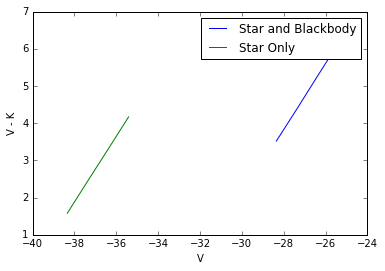

In [245]:
plt.plot(starplusbbV,starplusbbVminK,label="Star and Blackbody")
plt.plot(starV,starVminK,label="Star Only")
plt.legend()
plt.xlabel("V")
plt.ylabel("V - K")